In [36]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import SelectFromModel, RFE, RFECV
from sklearn.linear_model import ElasticNet, ElasticNetCV, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from abess import LinearRegression
from abess.decomposition import SparsePCA
from kennard_stone import train_test_split as ks_train_test_split
from sklearn.pipeline import Pipeline
# from genetic_selection import GeneticSelectionCV
import pandas as pd
import numpy as np

In [2]:
def extractDragonDescriptors(family_Y_df, descriptorFileString):
    family_X = pd.read_csv(descriptorFileString, sep='\t', index_col=0, low_memory=False)
    colsX = family_X.columns
    family_X_resetIndex = pd.DataFrame(family_X.to_numpy(), index=family_Y_df.index, columns=family_X.columns).replace('na', np.NaN)
    return family_X_resetIndex[colsX[1:]].dropna(axis=1, how='any')

In [3]:
global_Y = pd.read_csv('Data/exactPLS/global.csv', index_col=0)

In [4]:
global_X = extractDragonDescriptors(global_Y, 'Data/exactPLS/desc_global.txt')

In [5]:
global_Y.shape, global_X.shape

((1147, 2), (1147, 1023))

In [32]:
pd.concat([global_X, global_Y], axis = 1).corr()['PCE'].abs().sort_values(ascending=False).head(50) 

# try with 50 descriptors
# 50 best, 50 worst (see if get a good model)

PCE            1.000000
mintsC         0.474240
MaxtsC         0.432035
LOGPcons       0.405476
nCs            0.403580
C-002          0.403276
SssCH2         0.402945
nCsp3          0.397295
LOGP99         0.396008
H-046          0.395082
NssCH2         0.394894
RBN            0.392638
Eta_L          0.388005
nH             0.385415
Eta_C_A        0.371650
Si             0.367505
nAT            0.366850
Se             0.364584
nBT            0.362086
ESOL           0.361520
Eta_L_A        0.360554
Eta_C          0.358598
Sp             0.356409
Eta_epsi_A     0.356367
Vx             0.356214
VvdwMG         0.356214
Eta_D_epsiA    0.353482
MR99           0.345516
MRcons         0.345516
nC             0.343737
Eta_epsi       0.343428
H%             0.339274
Eta_alpha      0.338863
Eta_LR         0.336515
Eta_FL_A       0.334686
F01[C-C]       0.334518
Me             0.333158
MW             0.332756
nSK            0.332229
Fsp3           0.328980
nBO            0.322061
F10[C-C]       0

In [6]:
def returnNextRow(rowDf, to_drop):
    max = -200
    nextRow='None'
    for i in range(len(rowDf.columns)):
        if (rowDf[rowDf.columns[i]][0] > max) and (rowDf.columns[i] not in to_drop) and (rowDf[rowDf.columns[i]][0] != np.NaN):
            max = rowDf[rowDf.columns[i]][0]
            nextRow = rowDf.columns[i]
    return nextRow

def getTo_dropOfRow(rowDf, to_drop=[], threshold=0.95):
    for i in range(len(rowDf.columns)):
        if (rowDf[rowDf.columns[i]][0] > threshold) and (rowDf[rowDf.columns[i]][0] != np.NaN) and (rowDf.columns[i] not in to_drop):
            to_drop.append(rowDf.columns[i])
    return to_drop

def vWSPFeatureSelect(rowName,corr_matrix,to_drop=[],thresh=0.95):
    if rowName=='None':
        return to_drop
    else:
        to_DropThisRow = getTo_dropOfRow(corr_matrix.loc[[rowName]], to_drop, threshold=thresh) #array of column names
        nextRow = returnNextRow(corr_matrix.loc[[rowName]], to_DropThisRow)
        updateTo_drop = to_DropThisRow
        return vWSPFeatureSelect(rowName=nextRow, corr_matrix=corr_matrix,to_drop=updateTo_drop, thresh=0.95)
    
def vWSP(X_train, threshold=0.95):
    cor_matrix = X_train.corr().abs()
    upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    to_drop=vWSPFeatureSelect('MW', corr_matrix=upper_tri, to_drop=[], thresh=threshold) #MW chosen as seed
    X_train_rm = X_train.drop(to_drop, axis=1)
    return X_train_rm

In [10]:
global_X_train, global_X_test, global_Y_train, global_Y_test = ks_train_test_split(global_X, global_Y['PCE'], test_size=0.2)

In [17]:
global_X_train.shape

(917, 1023)

In [33]:
rfeRF = RandomForestRegressor()

min_features_to_select = 1

rfeCV = RFECV(
    estimator=rfeRF,
    step=1,
    cv=10,
    scoring="r2",
    min_features_to_select=min_features_to_select,
)

rfeCV.fit(global_X_train, global_Y_train)

# mid-point some threshold --> active and inactive
# one desc calculate avg std for the active/inactive
# is the diff between the active and inactive statistically different --> student t-test
# this desc can separate between active and inactive, select descriptors based off those that can and cannot
# might be transfer learning --> take families --> train test
# what happens

RFECV(cv=10, estimator=RandomForestRegressor(), scoring='r2')

Optimal numberof features : 617


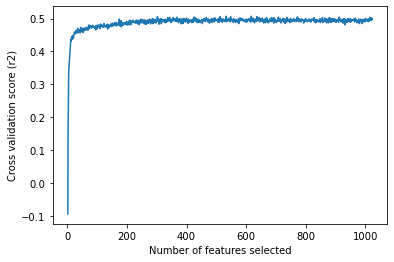

In [34]:
print("Optimal numberof features : %d" % rfeCV.n_features_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (r2)")
plt.plot(
    range(min_features_to_select, 1024),
    rfeCV.grid_scores_,
)
plt.show()

<b>RFE for 617 features</b>

In [42]:
model_RF = RandomForestRegressor()

rfe_617 = RFE(estimator=model_RF, n_features_to_select=617, step=1)

rfe_617.fit(global_X_train, global_Y_train)

RFE(estimator=RandomForestRegressor(), n_features_to_select=617)

In [51]:
global_X_train_rfe617 = global_X_train[global_X_train.columns[rfe_617.support_]]

global_X_train_rfe617

,MW,AMW,Se,Sp,Si,Me,Mp,Mi,GD,nAT,...,TPSA(NO),TPSA(Tot),LOGP99,LOGPcons,ESOL,SAacc,SAdon,Vx,VvdwMG,SAscore
S.No,,,,,,,,,,,,,,,,,,,,,
101,848.43,7.929252,105.4283,78.9553,117.9655,0.985311,0.737900,1.102481,0.038251,107,...,71.90,71.90,13.44840,9.886912,-11.185245,101.399329,42.683343,1061.877076,438.572572,6.829509
258,1231.10,7.327976,164.8459,118.7968,186.5253,0.981226,0.707124,1.110270,0.025862,168,...,100.62,128.86,20.89338,14.252522,-15.951736,135.582999,42.683343,1604.983389,661.157127,7.699039
162,579.73,9.202063,63.0652,49.0741,68.4905,1.001035,0.778954,1.087151,0.055749,63,...,78.91,135.39,9.29428,7.832295,-8.690492,115.673156,42.683343,691.644518,286.837917,4.141740
221,1981.43,6.496492,298.4845,201.8379,341.8844,0.978638,0.661764,1.120932,0.015483,305,...,137.84,166.08,36.76080,24.513496,-22.421193,178.475238,42.683343,2728.488372,1121.609989,8.609564
171,1699.87,6.666157,250.0523,170.7635,285.2381,0.980597,0.669661,1.118581,0.017993,255,...,137.54,137.54,30.91298,20.627868,-19.348302,176.458237,42.683343,2312.043189,950.935733,7.970872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,1385.47,7.827514,176.7550,124.1717,197.7790,0.998616,0.701535,1.117395,0.022882,177,...,149.66,234.38,20.67774,13.330043,-15.570325,204.023880,85.366686,1705.830565,702.487936,6.322707
24,706.50,11.214286,63.5161,49.7503,68.7152,1.008192,0.789687,1.090717,0.054878,63,...,62.54,122.87,9.13760,8.100322,-9.341160,99.221825,42.683343,730.249169,302.659496,4.055192
23,617.60,9.803175,63.7053,48.7615,68.9200,1.011195,0.773992,1.093968,0.054878,63,...,62.54,122.87,8.91940,7.911231,-8.676531,99.221825,42.683343,712.774086,295.497576,3.990880


<b>RFE for 400 features</b>

In [53]:
rfe_400 = RFE(estimator=model_RF, n_features_to_select=400, step=1)

rfe_400.fit(global_X_train, global_Y_train)

global_X_train_rfe400 = global_X_train[global_X_train.columns[rfe_400.support_]]


<b>RFE for first 200 features</b>

In [54]:
rfe_200 = RFE(estimator=model_RF, n_features_to_select=200, step=1)

rfe_200.fit(global_X_train, global_Y_train)

global_X_train_rfe200 = global_X_train[global_X_train.columns[rfe_200.support_]]


<b>RFE for first 100 features</b>

In [ ]:
rfe_100 = RFE(estimator=model_RF, n_features_to_select=100, step=1)

rfe_100.fit(global_X_train, global_Y_train)

global_X_train_rfe100 = global_X_train[global_X_train.columns[rfe_100.support_]]


<b>RFE for 50 features</b>

In [ ]:
rfe_50 = RFE(estimator=model_RF, n_features_to_select=100, step=1)

rfe_50.fit(global_X_train, global_Y_train)

global_X_train_rfe50 = global_X_train[global_X_train.columns[rfe_50.support_]]


In [ ]:
def getCorrOfModels(X_train_List, Y_train):
    for i in range(len(X_train_List)):
        modelRF = RandomForestRegressor(n_estimators=500)
        modelRF.X_train_List_train_List[i], Y_train)
        predict_train = modelRF.predict(X_train_List[i])
        predict_test_ = modelRF.predict(global_X_test[X_train_List[i].columns])
        r2_train = r2_score(global_Y_train, predict_train)
        r2_test_ = r2_score(global_Y_test, predict_test_)
        print(f"{r2_train}, {r2_test_}")
    

In [ ]:
getCorrOfModels([global_X_train_rfe617, global_X_train_rfe400, global_X_train_rfe200, global_X_train_rfe100, global_X_train_rfe50], global_Y_train)

In [ ]:
gridSearchRF = RandomForestRegressor()

param_grid={
    "n_estimators":[300, 500, 1000],
    "max_features":["auto","sqrt","log2"],
    "min_samples_leaf":[1,2,3]
}

grid = GridSearchCV(gridSearchRF, param_grid, cv=5)

grid.fit(global_X_train, global_Y_train)

grid.best_score_, grid.best_params_

In [ ]:
# Schro, lig prep --> 3D structure, protonate, C=OH, tautomers
# 